# 데이터 불러오기 및 이상치 처리

In [ ]:
# !pip install pdpbox

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Codestates Project 1/raw_data/train_data_final.csv')

In [ ]:
outlier = train[train.time < 1][['time','player_0_APM','player_1_APM']]
outlier

,time,player_0_APM,player_1_APM
187,0.50,140.0,60.0
200,0.13,454.0,123.0
672,0.77,152.0,73.0
708,0.45,178.0,320.0
747,0.75,76.0,71.0
...,...,...,...
38734,0.17,176.0,112.0
38746,0.77,108.0,52.0
38778,0.35,34.0,126.0
38865,0.55,160.0,105.0


In [ ]:
train = train.drop(outlier.index)
# len(outlier)
train

,winner,time,player_0_species,player_0_APM,player_0_attack,player_0_Ability,player_0_buildings,player_0_worker,player_0_nonworker,player_1_species,player_1_APM,player_1_attack,player_1_Ability,player_1_buildings,player_1_worker,player_1_nonworker
0,1,7.40,T,80.0,0,34,14,9,4,T,74.0,3,34,9,6,5
1,1,9.98,P,123.0,2,77,23,22,7,T,121.0,4,67,17,17,8
2,0,9.98,P,85.0,11,69,21,19,5,Z,137.0,7,85,15,23,16
3,0,9.98,T,139.0,8,82,18,7,18,P,163.0,17,89,20,24,5
4,0,5.65,T,171.0,14,57,9,14,4,Z,115.0,2,36,5,13,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38867,1,8.37,T,99.0,3,43,14,11,3,P,55.0,0,32,11,6,10
38868,0,9.98,T,81.0,14,63,19,7,14,P,78.0,1,28,8,11,3
38869,0,8.42,P,146.0,2,56,15,17,6,Z,100.0,6,53,5,13,14
38870,1,5.92,P,69.0,1,20,8,9,2,P,100.0,0,36,10,12,4


In [ ]:
train = train.drop(['player_0_APM', 'player_1_APM', 'player_0_Ability', 'player_1_Ability', 'player_0_worker','player_1_worker'], axis=1)

# ***스타크래프트 2 승패 정량적 분석***

# 개요 & 프로젝트의 목적

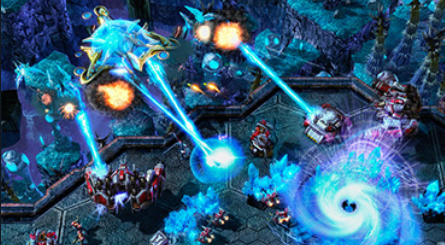

###### 실시간 전략 게임인 스타크래프트는 일대일 혹은 다대다의 승부에서 각자의 종족을 선택해 승부를 겨루는 게임입니다. 스타크래프트는 플레이하게 되는 맵의 지형과 전략이 더욱 중요한 게임이지만, 정량적인 분석이 필요없는 것은 아닙니다. 게임내 자원관리, 유닛 생산량, 특정 활동의 횟수, 이런 것들은 플레이어가 실시간으로 세우는 전략을 어떻게 실행하고 있느냐, 즉 플레이어의 ‘피지컬’ 을 판단할 수 있는 지표가 되기도 합니다. 따라서 이런 **정량적으로 판단 가능한 지표들을 선정, 제공하여 플레이어들 스스로 실력을 상승시키고 전략을 세우는 데 선택과 집중을 할 수 있게 돕는 것이 이번 프로젝트의 목적입니다.**


# 데이터에 대한 설명

- 2020년 4월 종료된 Blizzard 사의 Starcraft II 게임의 행동 데이터 분석 대회 (DACON)

데이터 선정 이유 : 
- 좋아하는 게임을 실제로 분석하는 것에 대한 개인적 흥미
- 지난 섹션에서도 진행하였으나 다양한 지표들을 도출해내지 못한 점

행동 데이터
 - 사용자가 서비스를 사용하며 겪게 되는 행동을 데이터화 한 것.
 - 이 프로젝트의 경우 두 플레이어가 게임 중 하게 되는 행동의 로그기록을 데이터화 한 것
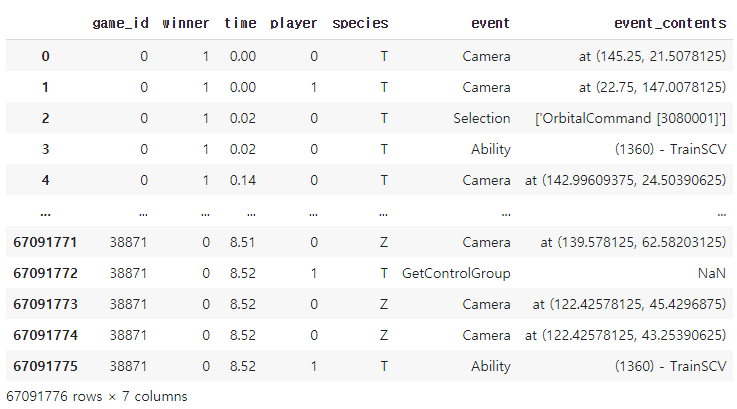

# Analysis


###### ✨분석에 앞서, 먼저 진행했던 프로젝트에서 도출해냈던 결과는 플레이어의 건물 및 유닛의 능력 사용횟수와 일꾼 생산 수가 승패에 가장 큰 영향을 미치는 것으로 나타났습니다. 이번 프로젝트에서는 그외의 게임내 의미있는 특성들을 추출해 문제를 풀어보고자 합니다.

### 지표로서 나타내고자 하는 행동 또는 특성
* 건설한 건물 수
* 일반 유닛 생산수
* 공격 명령 수

In [ ]:
train

,winner,time,player_0_species,player_0_attack,player_0_buildings,player_0_nonworker,player_1_species,player_1_attack,player_1_buildings,player_1_nonworker
0,1,7.40,T,0,14,4,T,3,9,5
1,1,9.98,P,2,23,7,T,4,17,8
2,0,9.98,P,11,21,5,Z,7,15,16
3,0,9.98,T,8,18,18,P,17,20,5
4,0,5.65,T,14,9,4,Z,2,5,7
...,...,...,...,...,...,...,...,...,...,...
38867,1,8.37,T,3,14,3,P,0,11,10
38868,0,9.98,T,14,19,14,P,1,8,3
38869,0,8.42,P,2,15,6,Z,6,5,14
38870,1,5.92,P,1,8,2,P,0,10,4


#### 베이스라인 정확도

In [ ]:
train.winner.value_counts(normalize=True) # 베이스 라인 정확도 

1    0.501262
0    0.498738
Name: winner, dtype: float64

### 특성별 승률 차이 살펴보기

* 승자/패자의 특성들의 분포를 확인하여 승자특성의 분포와 패자특성의 분포의 차이를 확인해본다 
* 승자와 패자의 특성의 대소 차이가 있을 때의 승률을 알아본다
* 승자/패자특성의 분포 평균의two-sample T-test를 실행해 통계적으로 차이점이 있는지 알아본다. 
* 통계적으로 차이점이 발견된다면 머신러닝 모델로 알아보기 전에 이 차이점이 실질적으로 승패에 영향을 미치는 것으로 결론을 내릴 수 있다. (이번 프로젝트에 사용된 데이터 한정)


#### 일반유닛 생산 수

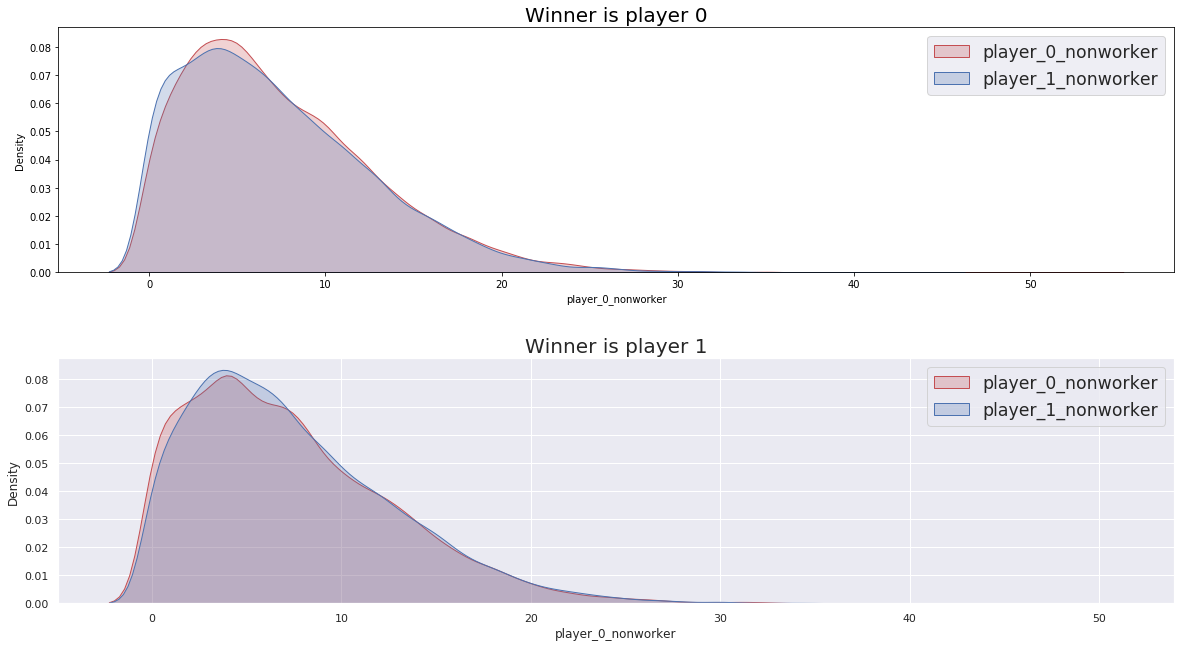

In [ ]:
winner0 = train[train.winner == 0]
winner1 = train[train.winner == 1]

plt.figure(figsize=(20,10))

plt.subplot(211)
sns.set(style="darkgrid")
sns.kdeplot(winner0['player_0_nonworker'], shade = True, color='r', label='player_0_nonworker')
sns.kdeplot(winner0['player_1_nonworker'], shade = True, color = 'b', label='player_1_nonworker')
plt.title('Winner is player 0', fontsize = 20)
plt.legend(fontsize='x-large')
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)

plt.subplot(212)
sns.set(style="darkgrid")
sns.kdeplot(winner1['player_0_nonworker'], shade = True, color='r', label='player_0_nonworker')
sns.kdeplot(winner1['player_1_nonworker'], shade = True, color = 'b', label='player_1_nonworker')
plt.title('Winner is player 1', fontsize = 20)
plt.legend(fontsize='x-large')
plt.show()

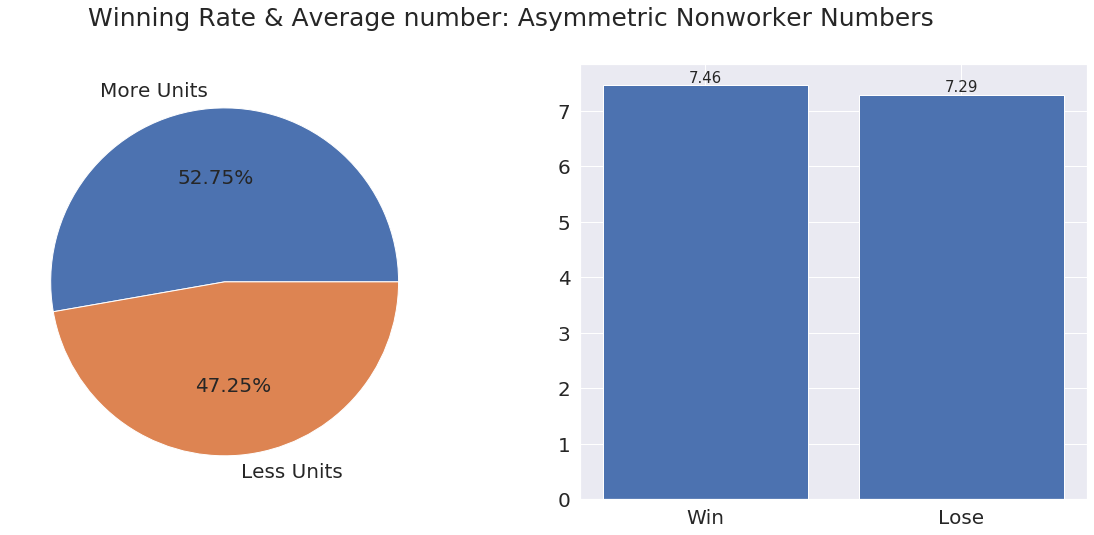

In [ ]:
winners_nonworker = train[train.player_0_nonworker > train.player_1_nonworker]['winner'].value_counts()[0] + train[train.player_0_nonworker < train.player_1_nonworker]['winner'].value_counts()[1]
losers_nonworker = train[train.player_0_nonworker > train.player_1_nonworker]['winner'].value_counts()[1] + train[train.player_0_nonworker < train.player_1_nonworker]['winner'].value_counts()[0]

win = round((np.mean(winner1.player_1_nonworker) + np.mean(winner0.player_0_nonworker))/2,2)
lose = round((np.mean(winner1.player_0_nonworker) + np.mean(winner0.player_1_nonworker))/2,2)

x = ['Win','Lose']
y = [win, lose]

fig, ax = plt.subplots(1, 2,figsize=(20, 8))

ax[0].pie([winners_nonworker, losers_nonworker], labels=['More Units','Less Units'],autopct='%1.2f%%', textprops={'fontsize': 20})
ax[1].bar(x, [win,lose])
plt.xticks( fontsize=20)
plt.yticks( fontsize=20)

for i, v in enumerate(x):
  plt.text(v, y[i], y[i], fontsize = 15, horizontalalignment='center', verticalalignment='bottom')  

plt.suptitle('Winning Rate & Average number: Asymmetric Nonworker Numbers', fontsize = 25)
plt.show()

In [ ]:
winners = list(winner1.player_1_nonworker) + list(winner0.player_0_nonworker)
losers = list(winner1.player_0_nonworker) + list(winner0.player_1_nonworker)
print(np.mean(winners))
print(np.mean(losers))
print(stats.ttest_ind(winners, losers))

7.463914842672358
7.287614189417797
Ttest_indResult(statistic=4.480674436919024, pvalue=7.451471569874855e-06)


#### 공격(attack) 명령 수

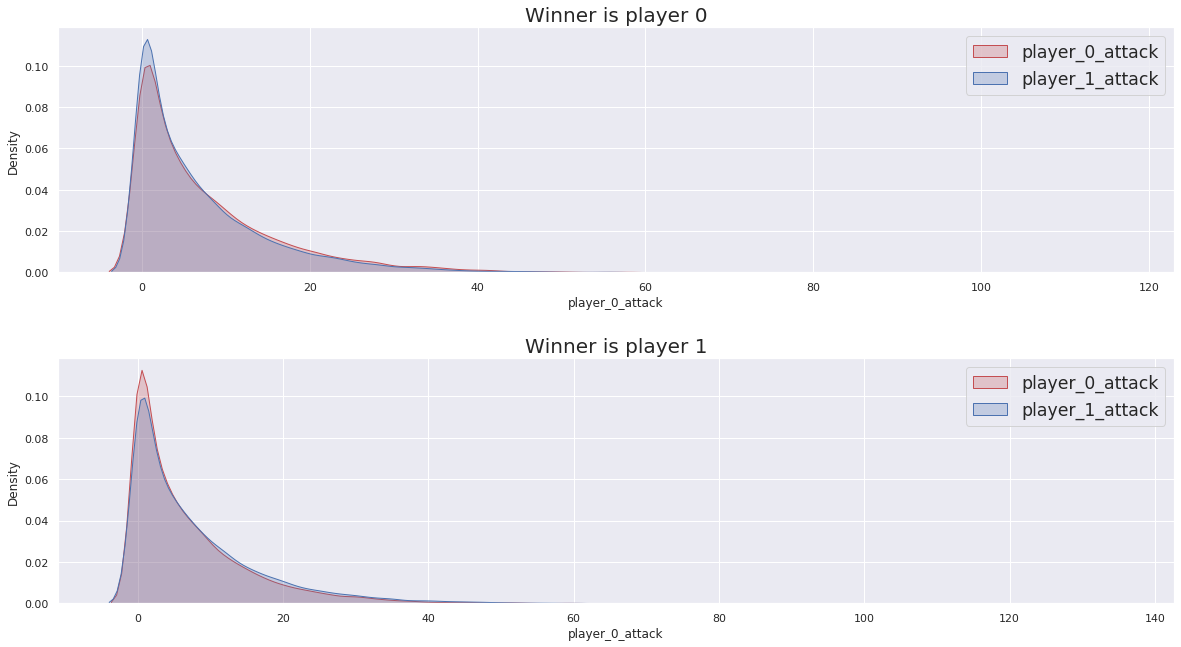

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(211)
sns.set(style="darkgrid")
sns.kdeplot(winner0['player_0_attack'], shade = True, color='r', label='player_0_attack')
sns.kdeplot(winner0['player_1_attack'], shade = True, color = 'b', label='player_1_attack')
plt.title('Winner is player 0', fontsize = 20)
plt.legend(fontsize='x-large')
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)

plt.subplot(212)
sns.set(style="darkgrid")
sns.kdeplot(winner1['player_0_attack'], shade = True, color='r', label='player_0_attack')
sns.kdeplot(winner1['player_1_attack'], shade = True, color = 'b', label='player_1_attack')
plt.title('Winner is player 1', fontsize = 20)
plt.legend(fontsize='x-large')
plt.show()

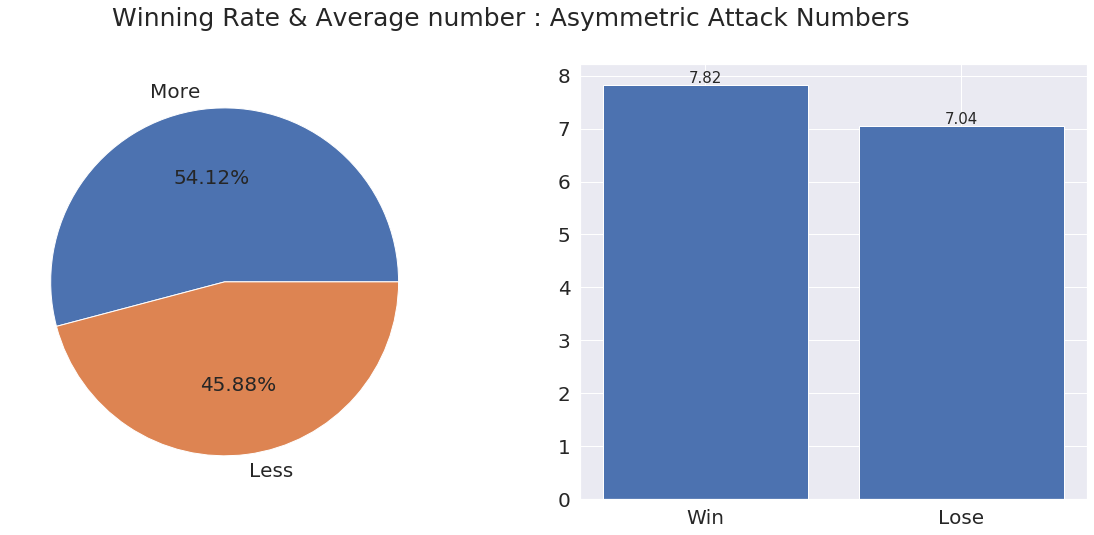

In [ ]:
winners_attack = train[train.player_0_attack > train.player_1_attack]['winner'].value_counts()[0] + train[train.player_0_attack < train.player_1_attack]['winner'].value_counts()[1]
losers_attack = train[train.player_0_attack > train.player_1_attack]['winner'].value_counts()[1] + train[train.player_0_attack < train.player_1_attack]['winner'].value_counts()[0]

win = round((np.mean(winner1.player_1_attack) + np.mean(winner0.player_0_attack))/2,2)
lose = round((np.mean(winner1.player_0_attack) + np.mean(winner0.player_1_attack))/2,2)

x = ['Win','Lose']
y = [win, lose]

fig, ax = plt.subplots(1, 2,figsize=(20, 8))

ax[0].pie([winners_attack, losers_attack], labels=['More','Less'],autopct='%1.2f%%', textprops={'fontsize': 20})
ax[1].bar(x, [win,lose])
plt.xticks( fontsize=20)
plt.yticks( fontsize=20)

for i, v in enumerate(x):
  plt.text(v, y[i], y[i], fontsize = 15, horizontalalignment='center', verticalalignment='bottom')  

plt.suptitle('Winning Rate & Average number : Asymmetric Attack Numbers', fontsize = 25)
plt.show()

In [ ]:
winners = list(winner1.player_1_attack) + list(winner0.player_0_attack)
losers = list(winner1.player_0_attack) + list(winner0.player_1_attack)
print(np.mean(winners))
print(np.mean(losers))
print(stats.ttest_ind(winners, losers))

7.819925565416548
7.04263071597741
Ttest_indResult(statistic=11.811438137308183, pvalue=3.632537092914392e-32)


#### 건물 수

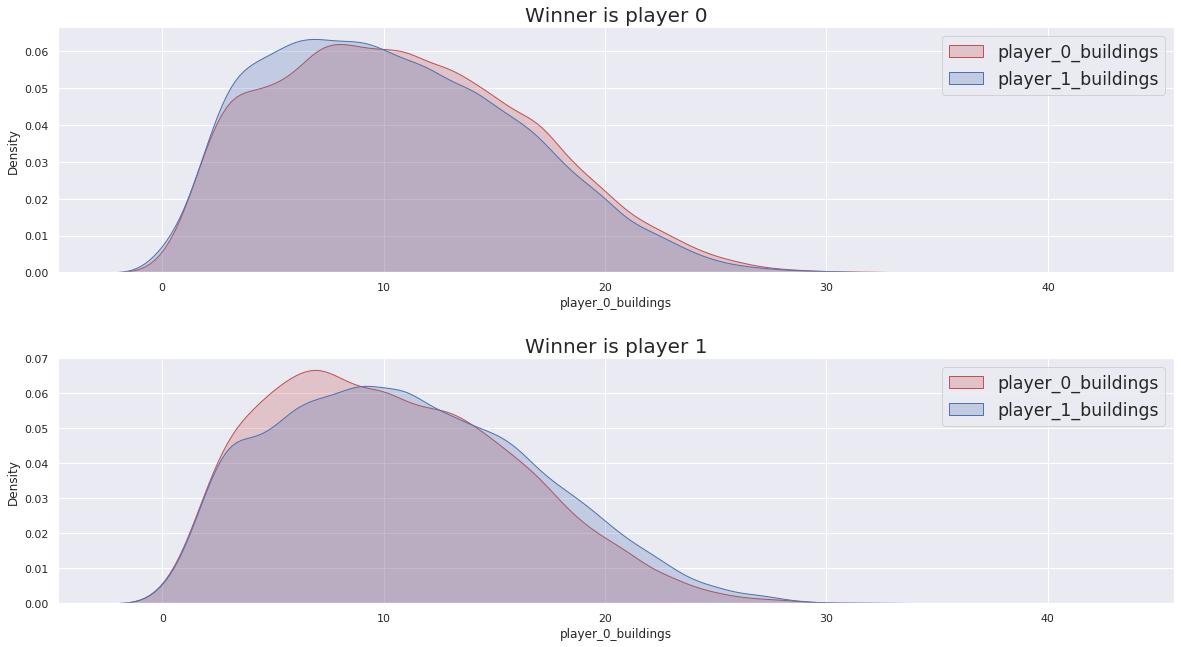

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(211)
sns.set(style="darkgrid")
sns.kdeplot(winner0['player_0_buildings'], shade = True, color='r', label='player_0_buildings')
sns.kdeplot(winner0['player_1_buildings'], shade = True, color = 'b', label='player_1_buildings')
plt.title('Winner is player 0', fontsize = 20)
plt.legend(fontsize='x-large')
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)

plt.subplot(212)
sns.set(style="darkgrid")
sns.kdeplot(winner1['player_0_buildings'], shade = True, color='r', label='player_0_buildings')
sns.kdeplot(winner1['player_1_buildings'], shade = True, color = 'b', label='player_1_buildings')
plt.title('Winner is player 1', fontsize = 20)
plt.legend(fontsize='x-large')
plt.show()

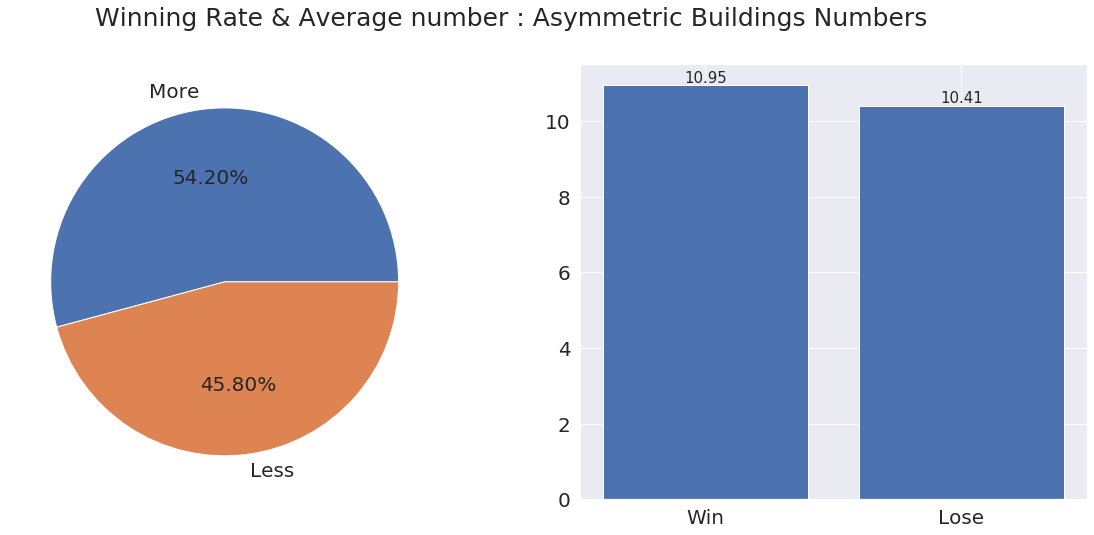

In [ ]:
winners_buildings = train[train.player_0_buildings > train.player_1_buildings]['winner'].value_counts()[0] + train[train.player_0_buildings < train.player_1_buildings]['winner'].value_counts()[1]
losers_buildings = train[train.player_0_buildings > train.player_1_buildings]['winner'].value_counts()[1] + train[train.player_0_buildings < train.player_1_buildings]['winner'].value_counts()[0]

win = round((np.mean(winner1.player_1_buildings) + np.mean(winner0.player_0_buildings))/2,2)
lose = round((np.mean(winner1.player_0_buildings) + np.mean(winner0.player_1_buildings))/2,2)

x = ['Win','Lose']
y = [win, lose]

fig, ax = plt.subplots(1, 2,figsize=(20, 8))

ax[0].pie([winners_buildings, losers_buildings], labels=['More','Less'],autopct='%1.2f%%', textprops={'fontsize': 20})
ax[1].bar(x, [win,lose])
plt.xticks( fontsize=20)
plt.yticks( fontsize=20)

for i, v in enumerate(x):
  plt.text(v, y[i], y[i], fontsize = 15, horizontalalignment='center', verticalalignment='bottom')  

plt.suptitle('Winning Rate & Average number : Asymmetric Buildings Numbers', fontsize = 25)
plt.show()

In [ ]:
winners = list(winner1.player_1_buildings) + list(winner0.player_0_buildings)
losers = list(winner1.player_0_buildings) + list(winner0.player_1_buildings)
print(np.mean(winners))
print(np.mean(losers))
print(stats.ttest_ind(winners, losers))

10.945189079457617
10.41230512974
Ttest_indResult(statistic=12.967934550867268, pvalue=2.040918461882811e-38)


#### 일꾼 유닛

KeyError: ignored

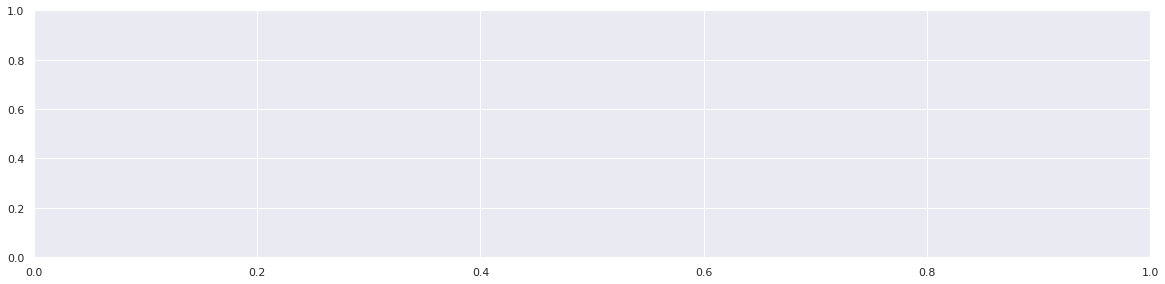

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(211)
sns.set(style="darkgrid")
sns.kdeplot(winner0['player_0_worker'], shade = True, color='r', label='player_0_worker')
sns.kdeplot(winner0['player_1_worker'], shade = True, color = 'b', label='player_1_worker')
plt.title('Winner is player 0', fontsize = 20)
plt.legend(fontsize='x-large')
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)

plt.subplot(212)
sns.set(style="darkgrid")
sns.kdeplot(winner1['player_0_worker'], shade = True, color='r', label='player_0_worker')
sns.kdeplot(winner1['player_1_worker'], shade = True, color = 'b', label='player_1_worker')
plt.title('Winner is player 1', fontsize = 20)
plt.legend(fontsize='x-large')
plt.show()

In [ ]:
winners_worker = train[train.player_0_worker > train.player_1_worker]['winner'].value_counts()[0] + train[train.player_0_worker < train.player_1_worker]['winner'].value_counts()[1]
losers_worker = train[train.player_0_worker > train.player_1_worker]['winner'].value_counts()[1] + train[train.player_0_worker < train.player_1_worker]['winner'].value_counts()[0]

win = round((np.mean(winner1.player_1_worker) + np.mean(winner0.player_0_worker))/2,2)
lose = round((np.mean(winner1.player_0_worker) + np.mean(winner0.player_1_worker))/2,2)

x = ['Win','Lose']
y = [win, lose]

fig, ax = plt.subplots(1, 2,figsize=(20, 8))

ax[0].pie([winners_worker, losers_worker], labels=['More Units','Less Units'],autopct='%1.2f%%', textprops={'fontsize': 20})
ax[1].bar(x, [win,lose])
plt.xticks( fontsize=20)
plt.yticks( fontsize=20)

for i, v in enumerate(x):
  plt.text(v, y[i], y[i], fontsize = 15, horizontalalignment='center', verticalalignment='bottom')  

plt.suptitle('Winning Rate & Average number : Asymmetric Worker Numbers', fontsize = 25)
plt.show()

In [ ]:
winners = list(winner1.player_1_worker) + list(winner0.player_0_worker)
losers = list(winner1.player_0_worker) + list(winner0.player_1_worker)
print(np.mean(winners))
print(np.mean(losers))
print(stats.ttest_ind(winners, losers))

#### Ability 수 

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(211)
sns.set(style="darkgrid")
sns.kdeplot(winner0['player_0_Ability'], shade = True, color='r', label='player_0_Ability')
sns.kdeplot(winner0['player_1_Ability'], shade = True, color = 'b', label='player_1_Ability')
plt.title('Winner is player 0', fontsize = 20)
plt.legend(fontsize='x-large')
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)

plt.subplot(212)
sns.set(style="darkgrid")
sns.kdeplot(winner1['player_0_Ability'], shade = True, color='r', label='player_0_Ability')
sns.kdeplot(winner1['player_1_Ability'], shade = True, color = 'b', label='player_1_Ability')
plt.title('Winner is player 1', fontsize = 20)
plt.legend(fontsize='x-large')
plt.show()

In [ ]:
winners_Ability = train[train.player_0_Ability > train.player_1_Ability]['winner'].value_counts()[0] + train[train.player_0_Ability < train.player_1_Ability]['winner'].value_counts()[1]
losers_Ability = train[train.player_0_Ability > train.player_1_Ability]['winner'].value_counts()[1] + train[train.player_0_Ability < train.player_1_Ability]['winner'].value_counts()[0]

win = round((np.mean(winner1.player_1_Ability) + np.mean(winner0.player_0_Ability))/2,2)
lose = round((np.mean(winner1.player_0_Ability) + np.mean(winner0.player_1_Ability))/2,2)

x = ['Win','Lose']
y = [win, lose]

fig, ax = plt.subplots(1, 2,figsize=(20, 8))

ax[0].pie([winners_Ability, losers_Ability], labels=['More','Less'],autopct='%1.2f%%', textprops={'fontsize': 20})
ax[1].bar(x, [win,lose])
plt.xticks( fontsize=20)
plt.yticks( fontsize=20)

for i, v in enumerate(x):
  plt.text(v, y[i], y[i], fontsize = 15, horizontalalignment='center', verticalalignment='bottom')  

plt.suptitle('Winning Rate & Average number : Asymmetric Ability Numbers', fontsize = 25)
plt.show()

In [ ]:
winners = list(winner1.player_1_Ability) + list(winner0.player_0_Ability)
losers = list(winner1.player_0_Ability) + list(winner0.player_1_Ability)
print(np.mean(winners))
print(np.mean(losers))
print(stats.ttest_ind(winners, losers))

#### APM 수

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(211)
sns.set(style="darkgrid")
sns.kdeplot(winner0['player_0_APM'], shade = True, color='r', label='player_0_APM')
sns.kdeplot(winner0['player_1_APM'], shade = True, color = 'b', label='player_1_APM')
plt.title('Winner is player 0', fontsize = 20)
plt.legend(fontsize='x-large')
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)

plt.subplot(212)
sns.set(style="darkgrid")
sns.kdeplot(winner1['player_0_APM'], shade = True, color='r', label='player_0_APM')
sns.kdeplot(winner1['player_1_APM'], shade = True, color = 'b', label='player_1_APM')
plt.title('Winner is player 1', fontsize = 20)
plt.legend(fontsize='x-large')
plt.show()

In [ ]:
winners_APM = train[train.player_0_APM > train.player_1_APM]['winner'].value_counts()[0] + train[train.player_0_APM < train.player_1_APM]['winner'].value_counts()[1]
losers_APM = train[train.player_0_APM > train.player_1_APM]['winner'].value_counts()[1] + train[train.player_0_APM < train.player_1_APM]['winner'].value_counts()[0]

win = round((np.mean(winner1.player_1_APM) + np.mean(winner0.player_0_APM))/2,2)
lose = round((np.mean(winner1.player_0_APM) + np.mean(winner0.player_1_APM))/2,2)

x = ['Win','Lose']
y = [win, lose]

fig, ax = plt.subplots(1, 2,figsize=(20, 8))

ax[0].pie([winners_APM, losers_APM], labels=['More Units','Less Units'],autopct='%1.2f%%', textprops={'fontsize': 20})
ax[1].bar(x, [win,lose])
plt.xticks( fontsize=20)
plt.yticks( fontsize=20)

for i, v in enumerate(x):
  plt.text(v, y[i], y[i], fontsize = 15, horizontalalignment='center', verticalalignment='bottom')  

plt.suptitle('Winning Rate & Average number : Asymmetric APM Numbers', fontsize = 25)
plt.show()

In [ ]:
winners = list(winner1.player_1_APM) + list(winner0.player_0_APM)
losers = list(winner1.player_0_APM) + list(winner0.player_1_APM)
print(np.mean(winners))
print(np.mean(losers))
print(stats.ttest_ind(winners, losers))

### 종족 밸런스 살펴보기

In [ ]:
ter_zer = train[(train.player_0_species =='T')&(train.player_1_species=='Z')]['winner'].value_counts()
ter_zer

0    2562
1    2501
Name: winner, dtype: int64

In [ ]:
zer_ter = train[(train.player_0_species =='Z')&(train.player_1_species=='T')]['winner'].value_counts()
zer_ter

0    2670
1    2486
Name: winner, dtype: int64

In [ ]:
ter_pro = train[(train.player_0_species =='T')&(train.player_1_species=='P')]['winner'].value_counts()
ter_pro

1    2157
0    2110
Name: winner, dtype: int64

In [ ]:
pro_ter = train[(train.player_0_species =='P')&(train.player_1_species=='T')]['winner'].value_counts()
pro_ter

1    2180
0    2158
Name: winner, dtype: int64

In [ ]:
zer_pro = train[(train.player_0_species =='Z')&(train.player_1_species=='P')]['winner'].value_counts()
zer_pro

0    1838
1    1801
Name: winner, dtype: int64

In [ ]:
pro_zer = train[(train.player_0_species =='P')&(train.player_1_species=='Z')]['winner'].value_counts()
pro_zer

1    1822
0    1695
Name: winner, dtype: int64

In [ ]:
terran = [[ter_zer[0] + zer_ter[1], ter_zer[1]+zer_ter[0]],
          [ter_pro[1]+pro_ter[0], ter_pro[0]+pro_ter[1]] ]
zerg = [ 
        [ter_zer[1]+zer_ter[0], ter_zer[0] + zer_ter[1]],
        [zer_pro[0]+pro_zer[0], zer_pro[1]+pro_zer[1]] ]
protoss = [
           [ter_pro[0]+pro_ter[1], ter_pro[1]+pro_ter[0]],
           [zer_pro[1]+pro_zer[1], zer_pro[0]+pro_zer[0]]
]


### 종족간 승률

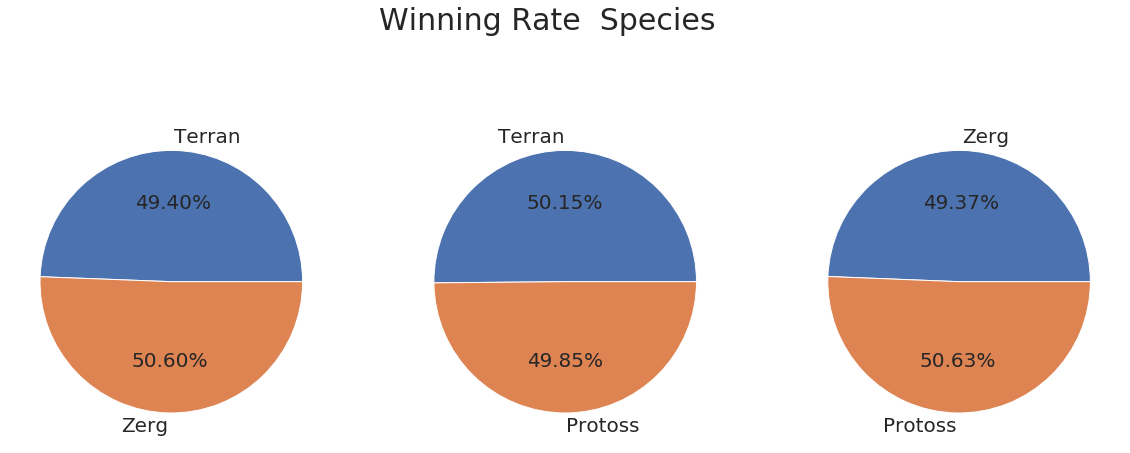

In [ ]:
# plt.figure(figsize=(20,20))

fig, ax = plt.subplots(1, 3,figsize=(20, 8))

ax[0].pie(terran[0], labels=['Terran', 'Zerg'],autopct='%1.2f%%', textprops={'fontsize': 20}) # terran vs zerg
ax[1].pie(terran[1], labels=['Terran','Protoss'],autopct='%1.2f%%', textprops={'fontsize': 20}) # terran vs protoss
ax[2].pie(zerg[1], labels = ['Zerg', 'Protoss'],autopct='%1.2f%%', textprops={'fontsize': 20})
plt.suptitle('Winning Rate  Species', fontsize=30)
plt.show()

### 종족 인코딩
###### Terran, T : 1
###### Zerg, Z : 2
###### Protoss, P : 3

In [ ]:
def species_encode(string):
    if string == 'T':
        return 1
    elif string == 'Z':
        return 2
    else :
        return 3

train.player_0_species = train.player_0_species.apply(species_encode)
train.player_1_species = train.player_1_species.apply(species_encode)
train[['player_0_species','player_1_species']]

,player_0_species,player_1_species
0,1,1
1,3,1
2,3,2
3,1,3
4,1,2
...,...,...
38867,1,3
38868,1,3
38869,3,2
38870,3,3


# 모델링
##### XGBOOST, RandomForest


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix, roc_curve,roc_auc_score,f1_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train.drop(['winner','time'],axis=1), train.winner, random_state= 2, test_size=0.3)

eval_set = [(X_train, y_train), 
            (X_val, y_val)]

### XGBOOST

In [ ]:
xgb = XGBClassifier(learning_rate= 0.2, n_estimators=100, max_depth=7, n_jobs=-1)
xgb.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=30)

[0]	validation_0-error:0.413891	validation_1-error:0.443567
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 30 rounds.
[1]	validation_0-error:0.397085	validation_1-error:0.44001
[2]	validation_0-error:0.387678	validation_1-error:0.438102
[3]	validation_0-error:0.383254	validation_1-error:0.435152
[4]	validation_0-error:0.379424	validation_1-error:0.433938
[5]	validation_0-error:0.374256	validation_1-error:0.430381
[6]	validation_0-error:0.369646	validation_1-error:0.428559
[7]	validation_0-error:0.368084	validation_1-error:0.42639
[8]	validation_0-error:0.365073	validation_1-error:0.426911
[9]	validation_0-error:0.362061	validation_1-error:0.428299
[10]	validation_0-error:0.35983	validation_1-error:0.42908
[11]	validation_0-error:0.357674	validation_1-error:0.428819
[12]	validation_0-error:0.356336	validation_1-error:0.427778
[13]	validation_0-error:0.355332	validation_1-error:0.427605

XGBClassifier(learning_rate=0.2, max_depth=7, n_jobs=-1)

### xgboost randomsearchCV

In [ ]:
y_val_pred = xgb.predict(X_val)
print(classification_report(y_val_pred, y_val))

              precision    recall  f1-score   support

           0       0.59      0.57      0.58      5931
           1       0.56      0.58      0.57      5596

    accuracy                           0.57     11527
   macro avg       0.58      0.58      0.57     11527
weighted avg       0.58      0.57      0.58     11527



In [ ]:
clf_xgb = RandomizedSearchCV(
    xgb,
    param_distributions = {
        'learning_rate':[0.1, 0.2, 0.3],
        'n_estimators' : [10, 50, 100, 200, 300], 
        'max_depth' : [3, 5, 7]
    },
    n_iter = 30,
    cv = 3,
    scoring='precision',
    verbose =1,
    n_jobs = -1
)
clf_xgb.fit(X_train, y_train)
print('최적 하이퍼파라미터: ', clf_xgb.best_params_)
print('Presision: ', clf_xgb.best_score_)
print(classification_report(clf_xgb.predict(X_val),y_val))

Fitting 3 folds for each of 30 candidates, totalling 90 fits
최적 하이퍼파라미터:  {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1}
Presision:  0.5789447990380975
              precision    recall  f1-score   support

           0       0.58      0.57      0.58      5838
           1       0.57      0.58      0.57      5689

    accuracy                           0.58     11527
   macro avg       0.58      0.58      0.58     11527
weighted avg       0.58      0.58      0.58     11527



### RandomForestClassifier

In [ ]:
rfc = RandomForestClassifier(max_depth=7, n_estimators=200, max_features=7)
rfc.fit(X_train, y_train)

y_val_pred_rfc = rfc.predict(X_val)
print(classification_report(y_val_pred_rfc, y_val))

              precision    recall  f1-score   support

           0       0.57      0.57      0.57      5754
           1       0.57      0.58      0.57      5773

    accuracy                           0.57     11527
   macro avg       0.57      0.57      0.57     11527
weighted avg       0.57      0.57      0.57     11527



In [ ]:
clf_rfc = RandomizedSearchCV(
    rfc,
    param_distributions = {
        'min_samples_leaf' : [500, 1000, 5000, 10000],
        'max_features' : [1, 3, 5, 7],
        'n_estimators' : [10, 50, 100, 200, 300], 
        'max_depth' : [3, 5, 7]
    },
    n_iter = 30,
    cv = 3,
    scoring='precision',
    verbose =1,
    n_jobs = -1
)
clf_rfc.fit(X_train, y_train)
print('최적 하이퍼파라미터: ', clf_rfc.best_params_)
print('Precision: ', clf_rfc.best_score_)
print(classification_report(clf_rfc.predict(X_val),y_val))

Fitting 3 folds for each of 30 candidates, totalling 90 fits
최적 하이퍼파라미터:  {'n_estimators': 300, 'min_samples_leaf': 1000, 'max_features': 1, 'max_depth': 7}
Precision:  0.5649814098621159
              precision    recall  f1-score   support

           0       0.56      0.55      0.55      5780
           1       0.55      0.56      0.56      5747

    accuracy                           0.56     11527
   macro avg       0.56      0.56      0.56     11527
weighted avg       0.56      0.56      0.56     11527



# 모델해석

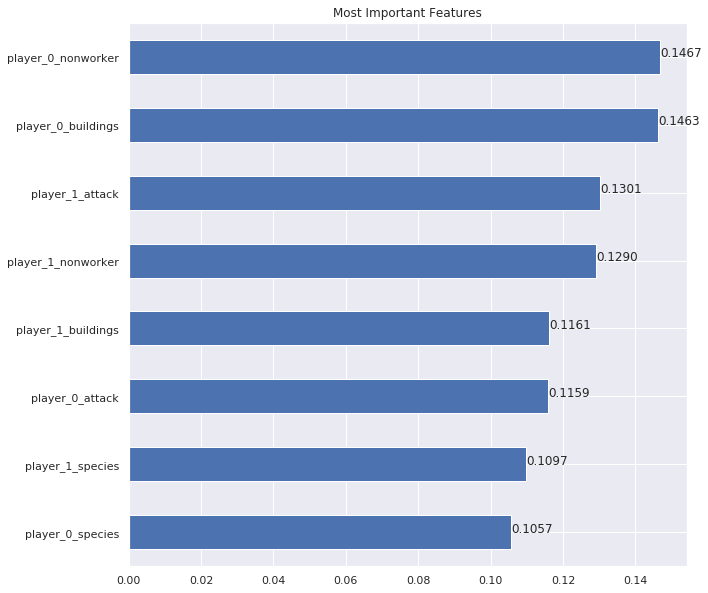

In [ ]:
importances = pd.Series(clf_xgb.best_estimator_.feature_importances_, X_train.columns)
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Most Important Features')
importances.sort_values()[-n:].plot.barh()
for index, value in enumerate(importances.sort_values()[-n:]):
  plt.text(value, index, str(value)[:6])

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

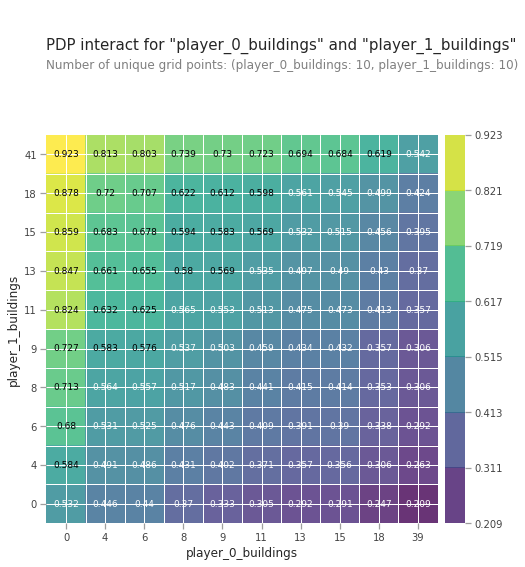

In [ ]:
bestmodel = clf_xgb.best_estimator_
features = ['player_0_buildings', 'player_1_buildings']

interaction = pdp_interact(
    model=bestmodel, 
    dataset=X_val,
    model_features=X_val.columns, 
    features=features
)
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

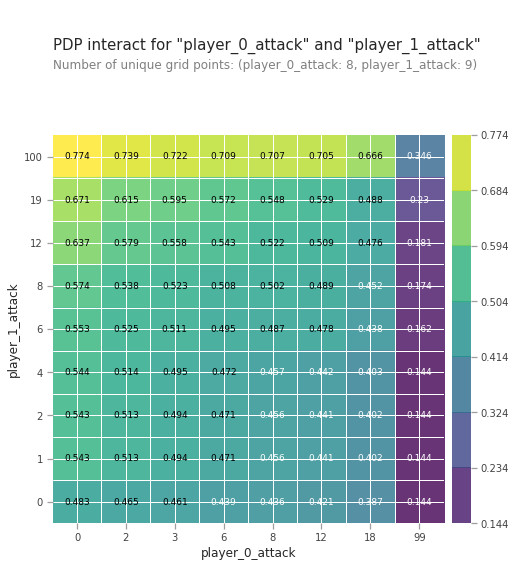

In [ ]:
features = ['player_0_attack', 'player_1_attack']

interaction = pdp_interact(
    model=bestmodel, 
    dataset=X_val,
    model_features=X_val.columns, 
    features=features
)
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

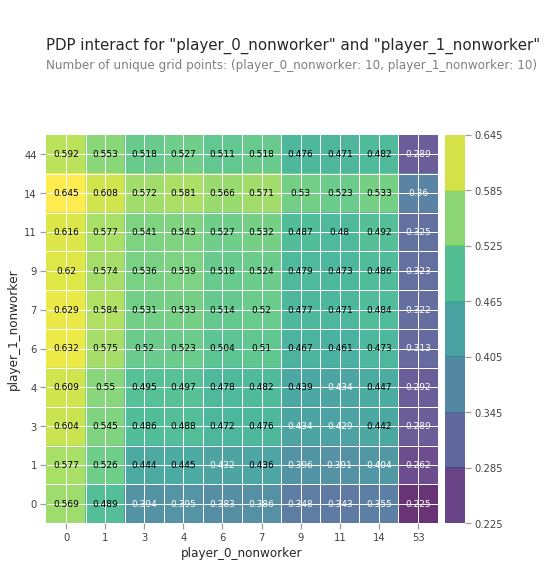

In [ ]:
features = ['player_0_nonworker', 'player_1_nonworker']

interaction = pdp_interact(
    model=bestmodel, 
    dataset=X_val,
    model_features=X_val.columns, 
    features=features
)
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

# 검증데이터 샘플로 예측해보기

In [ ]:
np.random.seed(4)
num = np.random.randint(0,len(y_val))
row = X_val.iloc[[num]]
print('예측용 샘플')
row

예측용 샘플


,player_0_species,player_0_attack,player_0_buildings,player_0_nonworker,player_1_species,player_1_attack,player_1_buildings,player_1_nonworker
3734,2,14,9,9,1,33,19,6


In [ ]:
print(f'예측하려는 데이터의 확률 결과: Player 1 승리 확률 {bestmodel.predict_proba(row)[0][1]:.4f}')
print('예측하려는 데이터의 예측 결과: Player', bestmodel.predict(row)[0], '승리')
print('예측하려는 데이터의 실제 결과: Player', y_val.iloc[num], '승리')

예측하려는 데이터의 확률 결과: Player 1 승리 확률 0.6218
예측하려는 데이터의 예측 결과: Player 1 승리
예측하려는 데이터의 실제 결과: Player 0 승리


# 결론
* 실제로 공격명령수, 일반유닛 생산수, 건물 생산수가 승률에 영향을 미친다.
* 정확도는 0.57로 앞서 진행했던 섹션 2 프로젝트의 결과보다는 조금 낮다. (0.61)

# 한계점과 아쉬운 점

1. 많은 특성들을 추출해내지 못했다

- 코드스테이츠 개인프로젝트 발표 시간제한, 프로젝트 제출기한 등 제약이 있었다.
2. 건물과 유닛이 쓸 수 있는 특수 능력들(업그레이드, 공격 마법, 방어 마법 등)이 있는데 각 유닛들과 건물들의 능력의 이름 하나하나 추출하기 어려웠다

- 플레이어들의 전략을 파악해 볼 수 있는 첫 건물생산시간, 첫 공격유닛 생산시간, 첫 자원저장 건물 생산시간 등 승패에 영향을 줄 수 있는 다양한 요소들을 파악하지 못했다.
3. 약 4만 개의 모든 게임의 최대 시간이 10분을 넘지 않았다

- 10분이 넘는 게임들을 일반화할 방식을 고안해내지 못했다
- 데이터 자체가 프로게이머들의 게임 데이터가 아니기에 '정석' 플레이에 대한 정량적 데이터를 수집하고 분석하는데 어려움이 있었다.
###### * 프로게이머들의 전략은 정석적인 전략과 기습적인 전략, 그리고 이들에 대한 '카운터' 전략으로 나뉘는데 이에 따라 경기시간이 몇분 단위에서 40분 안팎으로 다양해집니다. 그러나 이번 프로젝트에 사용된 데이터에 기록된 시간이 모두 10분을 넘기지 않았다는 것은 게이머들의 다양성을 담지 못하였다고 판된됩니다.

 

4. 데이터 자체에서 게임에서 정말 중요한 특성이 없었다.

- 게임에서 자원 채취량, 처치한 적 유닛 수, 파괴한 적 건물 수 등을 파악할 수 없어 수치로 볼 수 있는 경기 양상을 파악할 수 없었다